# Analyzing Abstention and Hedging Metrics

This notebook provides visualizations and analysis of the Confident-Abstain (CA) and Hedging (HEDGE) metrics computed over the experimental results.


In [21]:
import json
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# Add the project root to the path to allow imports
repo_root = Path().absolute()
sys.path.insert(0, str(repo_root))



## Load the Metrics Data

First, let's load the metrics data that was generated by the `run_metrics_analysis.py` script.


In [22]:
# Path to the metrics directory
metrics_dir = Path('./results/metrics_analysis')

# Find all run directories
run_dirs = [d for d in metrics_dir.iterdir() if d.is_dir() and d.name.startswith('run_')]

if not run_dirs:
    print("No metrics data found. Please run the run_metrics_analysis.py script first.")
else:
    print(f"Found {len(run_dirs)} runs with metrics data:")
    for d in run_dirs:
        print(f"  - {d.name}")

    # Use the most recent run by default
    latest_run = sorted(run_dirs)[-1]
    print(f"\nUsing latest run: {latest_run.name}")


Found 1 runs with metrics data:
  - run_20250911_062422

Using latest run: run_20250911_062422


In [7]:
# Load the all_metrics.csv file from the latest run
try:
    metrics_file = latest_run / 'all_metrics.csv'
    metrics_df = pd.read_csv(metrics_file)
    print(f"Loaded {len(metrics_df)} metric records")

    # Display the first few rows and column names
    print("\nColumns in metrics_df:")
    print(metrics_df.columns.tolist())
    metrics_df.head()
except NameError:
    print("No metrics data available. Please run the run_metrics_analysis.py script first.")


Loaded 63000 metric records

Columns in metrics_df:
['run', 'experiment', 'form', 'label_type', 'permutation', 'id', 'question', 'answer', 'subject', 'difficulty', 'split', 'pred_label', 'canonical_label', 'score', 'ca_score', 'hedge_score', 'canonical_probs', 'canonical_probs_norm']


## Analyze Metrics by Form

Let's analyze how the CA and HEDGE metrics vary across different prompt forms.


In [23]:
try:
    # Load the form summary
    form_summary_file = latest_run / 'form_summary.csv'
    form_df = pd.read_csv(form_summary_file)

    # Display the summary
    form_df
except NameError:
    print("No metrics data available.")


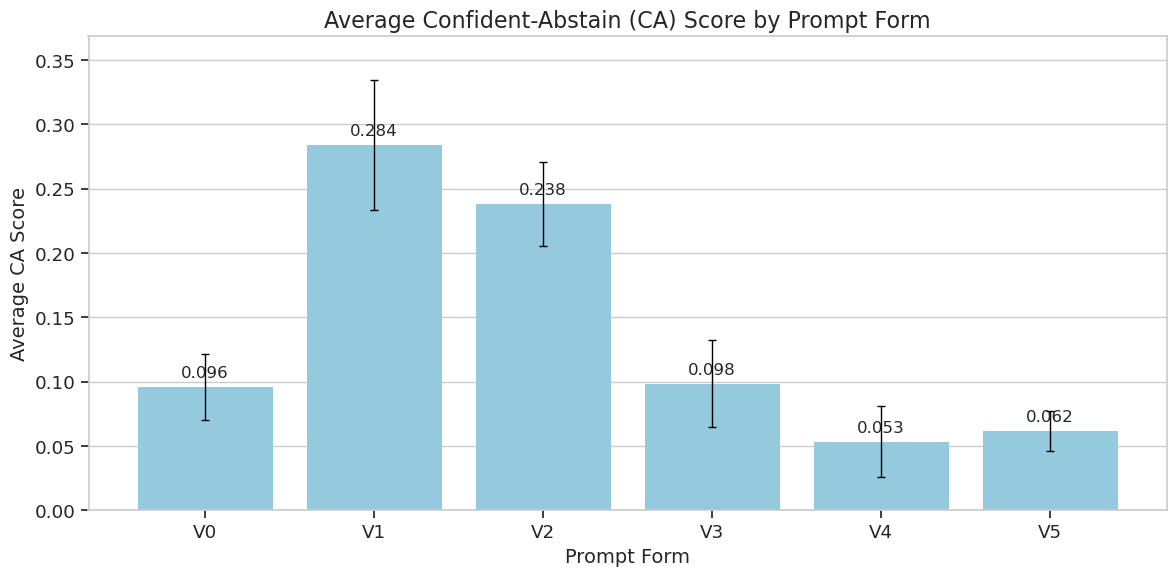

In [9]:
try:
    # Create a bar plot of CA scores by form
    plt.figure(figsize=(12, 6))

    # Sort by form
    form_df = form_df.sort_values('form')

    # First, we need to calculate standard error across permutations for each form
    # Group metrics by form and permutation to get per-experiment metrics
    if 'permutation' in metrics_df.columns:
        exp_form_metrics = metrics_df.groupby(['form', 'permutation'])['ca_score'].mean().reset_index()
    else:
        # If permutation is not available, try to extract it from experiment_name
        if 'experiment_name' in metrics_df.columns:
            # Extract permutation from experiment_name (assuming format like "V0_alpha_p1")
            metrics_df['permutation'] = metrics_df['experiment_name'].str.extract(r'p(\d+)')
            exp_form_metrics = metrics_df.groupby(['form', 'permutation'])['ca_score'].mean().reset_index()
        else:
            # If neither is available, just use form
            print("Warning: No permutation or experiment_name column found. Using only form for grouping.")
            exp_form_metrics = metrics_df.groupby(['form'])['ca_score'].mean().reset_index()
            # Add a dummy permutation column for consistency
            exp_form_metrics['permutation'] = 'p1'

    # Then calculate mean and std across permutations for each form
    form_stats = exp_form_metrics.groupby('form')['ca_score'].agg(['mean', 'std', 'count']).reset_index()
    form_stats.rename(columns={'mean': 'ca_score_mean_check'}, inplace=True)

    # Calculate standard error
    form_stats['se'] = form_stats['std'] / np.sqrt(form_stats['count'])

    # Merge with form_df to get the standard error
    form_df = pd.merge(form_df, form_stats[['form', 'se']], on='form', how='left')

    # Plot CA scores without error bars (we'll add them manually)
    ax = sns.barplot(x='form', y='ca_score_mean', data=form_df, color='skyblue', errorbar=None)

    # Add custom error bars
    for i, row in form_df.iterrows():
        x = i
        y = row['ca_score_mean']
        se = row['se']

        if not pd.isna(se) and se > 0:
            ax.errorbar(
                x, y,
                yerr=se,
                fmt='none', color='black', capsize=3, elinewidth=1
            )

    # Add labels and title
    plt.title('Average Confident-Abstain (CA) Score by Prompt Form', fontsize=16)
    plt.xlabel('Prompt Form', fontsize=14)
    plt.ylabel('Average CA Score', fontsize=14)

    # Calculate appropriate y-axis limits based on data
    max_value = form_df['ca_score_mean'].max()
    y_max = max_value * 1.3  # Add 30% padding above the max value
    plt.ylim(0, y_max)

    # Add value labels on top of bars
    for i, v in enumerate(form_df['ca_score_mean']):
        ax.text(i, v + (y_max * 0.02), f'{v:.3f}', ha='center', fontsize=12)

    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error: {str(e)}")


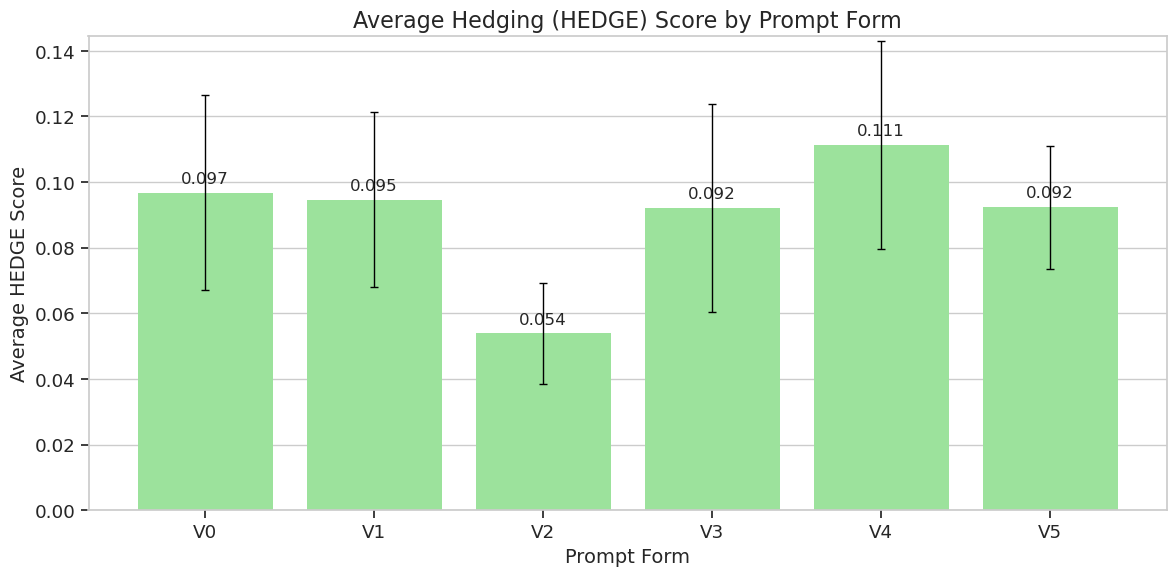

In [24]:
try:
    # Create a bar plot of HEDGE scores by form
    plt.figure(figsize=(12, 6))

    # First, we need to calculate standard error across permutations for each form
    # Group metrics by form and permutation to get per-experiment metrics
    if 'permutation' in metrics_df.columns:
        exp_form_metrics = metrics_df.groupby(['form', 'permutation'])['hedge_score'].mean().reset_index()
    else:
        # If permutation is not available, try to extract it from experiment_name
        if 'experiment_name' in metrics_df.columns:
            # Extract permutation from experiment_name (assuming format like "V0_alpha_p1")
            if 'permutation' not in metrics_df.columns:  # Only extract if not already done
                metrics_df['permutation'] = metrics_df['experiment_name'].str.extract(r'p(\d+)')
            exp_form_metrics = metrics_df.groupby(['form', 'permutation'])['hedge_score'].mean().reset_index()
        else:
            # If neither is available, just use form
            print("Warning: No permutation or experiment_name column found. Using only form for grouping.")
            exp_form_metrics = metrics_df.groupby(['form'])['hedge_score'].mean().reset_index()
            # Add a dummy permutation column for consistency
            exp_form_metrics['permutation'] = 'p1'

    # Then calculate mean and std across permutations for each form
    form_stats = exp_form_metrics.groupby('form')['hedge_score'].agg(['mean', 'std', 'count']).reset_index()
    form_stats.rename(columns={'mean': 'hedge_score_mean_check'}, inplace=True)

    # Calculate standard error
    form_stats['se'] = form_stats['std'] / np.sqrt(form_stats['count'])

    # Merge with form_df to get the standard error
    form_df = pd.merge(form_df, form_stats[['form', 'se']], on='form', how='left', suffixes=('', '_hedge'))

    # Plot HEDGE scores without error bars (we'll add them manually)
    ax = sns.barplot(x='form', y='hedge_score_mean', data=form_df, color='lightgreen', errorbar=None)

    # Add custom error bars
    for i, row in form_df.iterrows():
        x = i
        y = row['hedge_score_mean']
        se = row['se_hedge'] if 'se_hedge' in row else row['se']

        if not pd.isna(se) and se > 0:
            ax.errorbar(
                x, y,
                yerr=se,
                fmt='none', color='black', capsize=3, elinewidth=1
            )

    # Add labels and title
    plt.title('Average Hedging (HEDGE) Score by Prompt Form', fontsize=16)
    plt.xlabel('Prompt Form', fontsize=14)
    plt.ylabel('Average HEDGE Score', fontsize=14)

    # Calculate appropriate y-axis limits based on data
    max_value = form_df['hedge_score_mean'].max()
    y_max = max_value * 1.3  # Add 30% padding above the max value
    plt.ylim(0, y_max)

    # Add value labels on top of bars
    for i, v in enumerate(form_df['hedge_score_mean']):
        ax.text(i, v + (y_max * 0.02), f'{v:.3f}', ha='center', fontsize=12)

    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error: {str(e)}")


## Analyze Metrics by Label Type

Let's analyze how the metrics vary between alphabetic (A,B,C,D,E) and numeric (1,2,3,4,5) labels.


In [25]:
try:
    # Load the label type summary
    label_summary_file = latest_run / 'label_type_summary.csv'
    label_df = pd.read_csv(label_summary_file)

    # Display the summary
    label_df
except NameError:
    print("No metrics data available.")


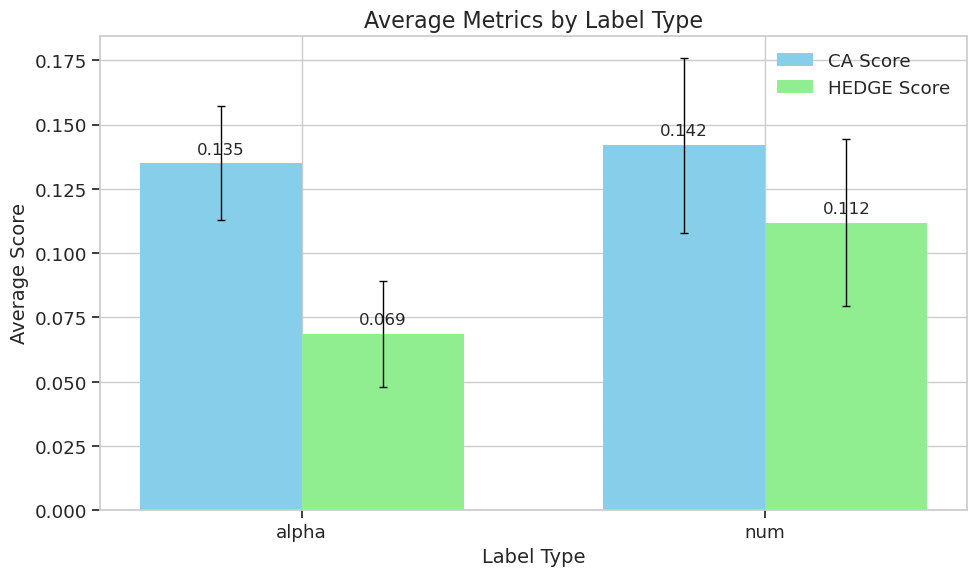

In [26]:
try:
    # Create a grouped bar plot for CA and HEDGE scores by label type
    plt.figure(figsize=(10, 6))

    # First, calculate standard errors across permutations for each label type
    # Group metrics by label_type and permutation to get per-experiment metrics
    if 'permutation' in metrics_df.columns:
        exp_label_ca = metrics_df.groupby(['label_type', 'permutation'])['ca_score'].mean().reset_index()
        exp_label_hedge = metrics_df.groupby(['label_type', 'permutation'])['hedge_score'].mean().reset_index()
    else:
        # If permutation is not available, try to extract it from experiment_name
        if 'experiment_name' in metrics_df.columns:
            # Extract permutation from experiment_name (assuming format like "V0_alpha_p1")
            if 'permutation' not in metrics_df.columns:  # Only extract if not already done
                metrics_df['permutation'] = metrics_df['experiment_name'].str.extract(r'p(\d+)')
            exp_label_ca = metrics_df.groupby(['label_type', 'permutation'])['ca_score'].mean().reset_index()
            exp_label_hedge = metrics_df.groupby(['label_type', 'permutation'])['hedge_score'].mean().reset_index()
        else:
            # If neither is available, just use label_type
            print("Warning: No permutation or experiment_name column found. Using only label_type for grouping.")
            exp_label_ca = metrics_df.groupby(['label_type'])['ca_score'].mean().reset_index()
            exp_label_hedge = metrics_df.groupby(['label_type'])['hedge_score'].mean().reset_index()
            # Add a dummy permutation column for consistency
            exp_label_ca['permutation'] = 'p1'
            exp_label_hedge['permutation'] = 'p1'

    # Then calculate mean and std across permutations for each label type
    label_ca_stats = exp_label_ca.groupby('label_type')['ca_score'].agg(['mean', 'std', 'count']).reset_index()
    label_hedge_stats = exp_label_hedge.groupby('label_type')['hedge_score'].agg(['mean', 'std', 'count']).reset_index()

    # Calculate standard error
    label_ca_stats['se'] = label_ca_stats['std'] / np.sqrt(label_ca_stats['count'])
    label_hedge_stats['se'] = label_hedge_stats['std'] / np.sqrt(label_hedge_stats['count'])

    # Merge with label_df to get the standard errors
    label_df = pd.merge(label_df, label_ca_stats[['label_type', 'se']], on='label_type', how='left')
    label_df = pd.merge(label_df, label_hedge_stats[['label_type', 'se']], on='label_type', how='left', suffixes=('_ca', '_hedge'))

    # Set up positions for grouped bars
    x = np.arange(len(label_df['label_type']))
    width = 0.35

    # Create bars
    ax = plt.subplot()
    ca_bars = ax.bar(x - width/2, label_df['ca_score_mean'], width, label='CA Score', color='skyblue')
    hedge_bars = ax.bar(x + width/2, label_df['hedge_score_mean'], width, label='HEDGE Score', color='lightgreen')

    # Add error bars
    for i, row in label_df.iterrows():
        # CA score error bar
        x_pos = i - width/2
        y = row['ca_score_mean']
        se = row['se_ca']
        if not pd.isna(se) and se > 0:
            ax.errorbar(x_pos, y, yerr=se, fmt='none', color='black', capsize=3, elinewidth=1)

        # HEDGE score error bar
        x_pos = i + width/2
        y = row['hedge_score_mean']
        se = row['se_hedge']
        if not pd.isna(se) and se > 0:
            ax.errorbar(x_pos, y, yerr=se, fmt='none', color='black', capsize=3, elinewidth=1)

    # Add labels and title
    ax.set_title('Average Metrics by Label Type', fontsize=16)
    ax.set_xlabel('Label Type', fontsize=14)
    ax.set_ylabel('Average Score', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(label_df['label_type'])

    # Calculate appropriate y-axis limits based on data
    max_ca = label_df['ca_score_mean'].max()
    max_hedge = label_df['hedge_score_mean'].max()
    max_value = max(max_ca, max_hedge)
    y_max = max_value * 1.3  # Add 30% padding above the max value
    ax.set_ylim(0, y_max)

    ax.legend()

    # Add value labels on top of bars
    for bar in ca_bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + (y_max * 0.02),
                f'{height:.3f}', ha='center', fontsize=12)

    for bar in hedge_bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + (y_max * 0.02),
                f'{height:.3f}', ha='center', fontsize=12)

    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error: {str(e)}")


## Distribution of Metrics

Let's look at the distribution of CA and HEDGE scores across all questions.


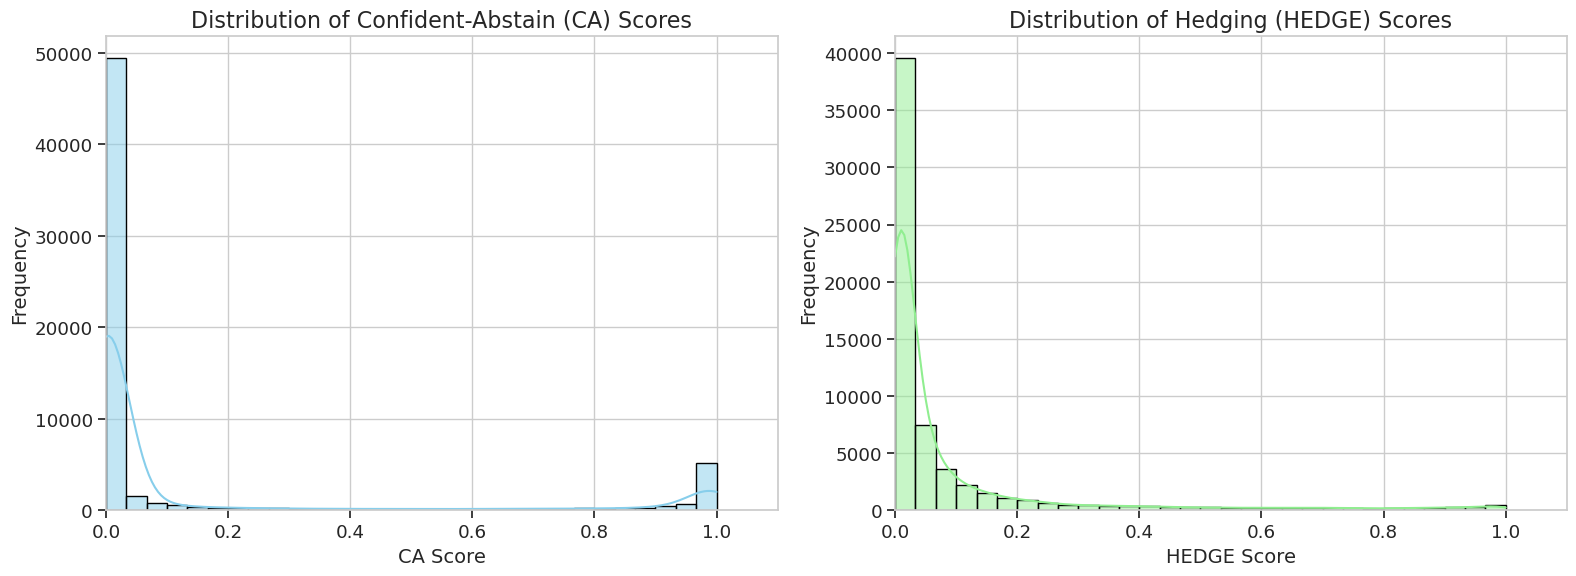

In [27]:
try:
    # Create histograms of CA and HEDGE scores
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # CA score histogram
    sns.histplot(metrics_df['ca_score'], bins=30, kde=True, ax=ax1, color='skyblue')
    ax1.set_title('Distribution of Confident-Abstain (CA) Scores', fontsize=16)
    ax1.set_xlabel('CA Score', fontsize=14)
    ax1.set_ylabel('Frequency', fontsize=14)

    # Set x-axis limit for CA scores based on data
    ca_max = metrics_df['ca_score'].max()
    ca_99th_percentile = metrics_df['ca_score'].quantile(0.99)  # Use 99th percentile to avoid outliers
    ax1.set_xlim(0, min(ca_max * 1.1, ca_99th_percentile * 1.3))

    # HEDGE score histogram
    sns.histplot(metrics_df['hedge_score'], bins=30, kde=True, ax=ax2, color='lightgreen')
    ax2.set_title('Distribution of Hedging (HEDGE) Scores', fontsize=16)
    ax2.set_xlabel('HEDGE Score', fontsize=14)
    ax2.set_ylabel('Frequency', fontsize=14)

    # Set x-axis limit for HEDGE scores based on data
    hedge_max = metrics_df['hedge_score'].max()
    hedge_99th_percentile = metrics_df['hedge_score'].quantile(0.99)  # Use 99th percentile to avoid outliers
    ax2.set_xlim(0, min(hedge_max * 1.1, hedge_99th_percentile * 1.3))

    plt.tight_layout()
    plt.show()
except NameError:
    print("No metrics data available.")


## Correlation Between Metrics and Likert Scores

Let's examine the relationship between our metrics and the Likert scores.


Correlation between CA score and Likert score: -0.0476
Correlation between HEDGE score and Likert score: -0.2082


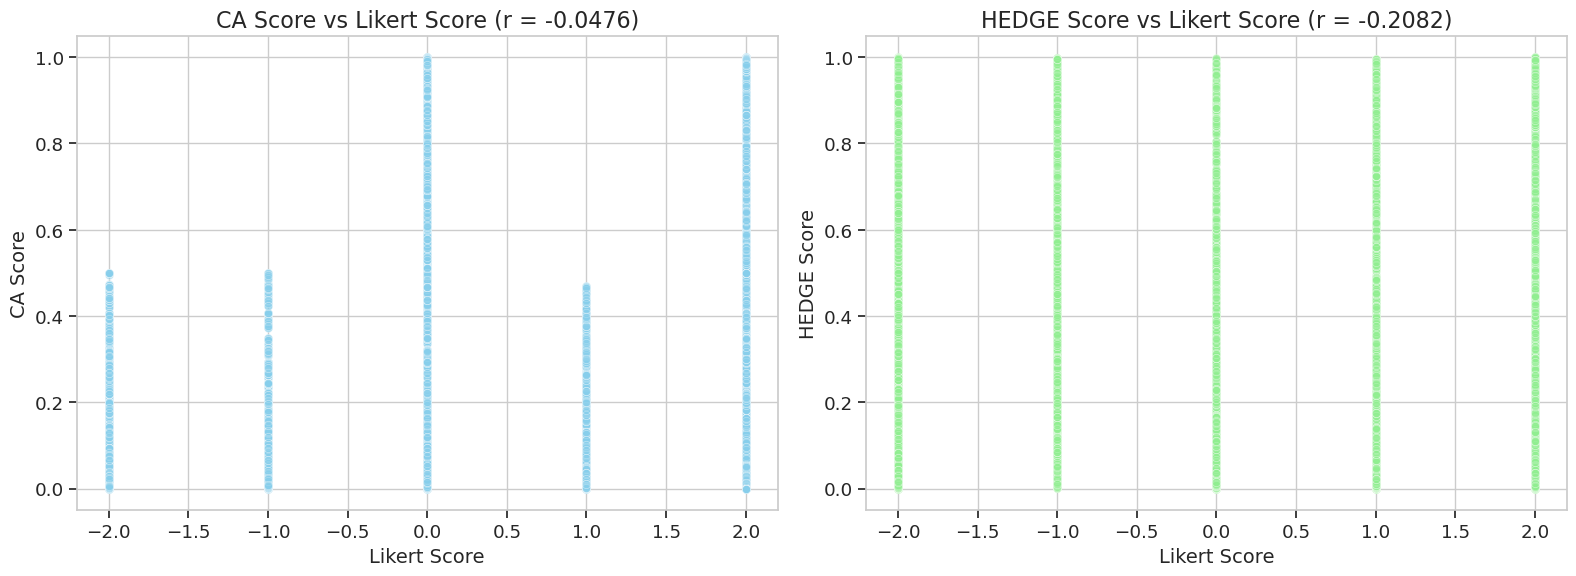

In [28]:
try:
    # Calculate correlation
    corr_ca_likert = metrics_df['ca_score'].corr(metrics_df['score'])
    corr_hedge_likert = metrics_df['hedge_score'].corr(metrics_df['score'])

    print(f"Correlation between CA score and Likert score: {corr_ca_likert:.4f}")
    print(f"Correlation between HEDGE score and Likert score: {corr_hedge_likert:.4f}")

    # Create scatter plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # CA score vs Likert score
    sns.scatterplot(x='score', y='ca_score', data=metrics_df, alpha=0.5, ax=ax1, color='skyblue')
    ax1.set_title(f'CA Score vs Likert Score (r = {corr_ca_likert:.4f})', fontsize=16)
    ax1.set_xlabel('Likert Score', fontsize=14)
    ax1.set_ylabel('CA Score', fontsize=14)

    # HEDGE score vs Likert score
    sns.scatterplot(x='score', y='hedge_score', data=metrics_df, alpha=0.5, ax=ax2, color='lightgreen')
    ax2.set_title(f'HEDGE Score vs Likert Score (r = {corr_hedge_likert:.4f})', fontsize=16)
    ax2.set_xlabel('Likert Score', fontsize=14)
    ax2.set_ylabel('HEDGE Score', fontsize=14)

    plt.tight_layout()
    plt.show()
except NameError:
    print("No metrics data available.")


## Metrics by Subject and Difficulty

Let's analyze how the metrics vary across different subjects and difficulty levels.


In [15]:
try:
    # Group by subject and compute mean metrics
    subject_summary = metrics_df.groupby('subject').agg({
        'ca_score': 'mean',
        'hedge_score': 'mean',
        'score': 'mean',
        'id': 'count'
    }).reset_index()

    subject_summary = subject_summary.rename(columns={'id': 'count'})
    subject_summary = subject_summary.sort_values('ca_score', ascending=False)

    # Display the summary
    subject_summary.head(10)
except NameError:
    print("No metrics data available.")


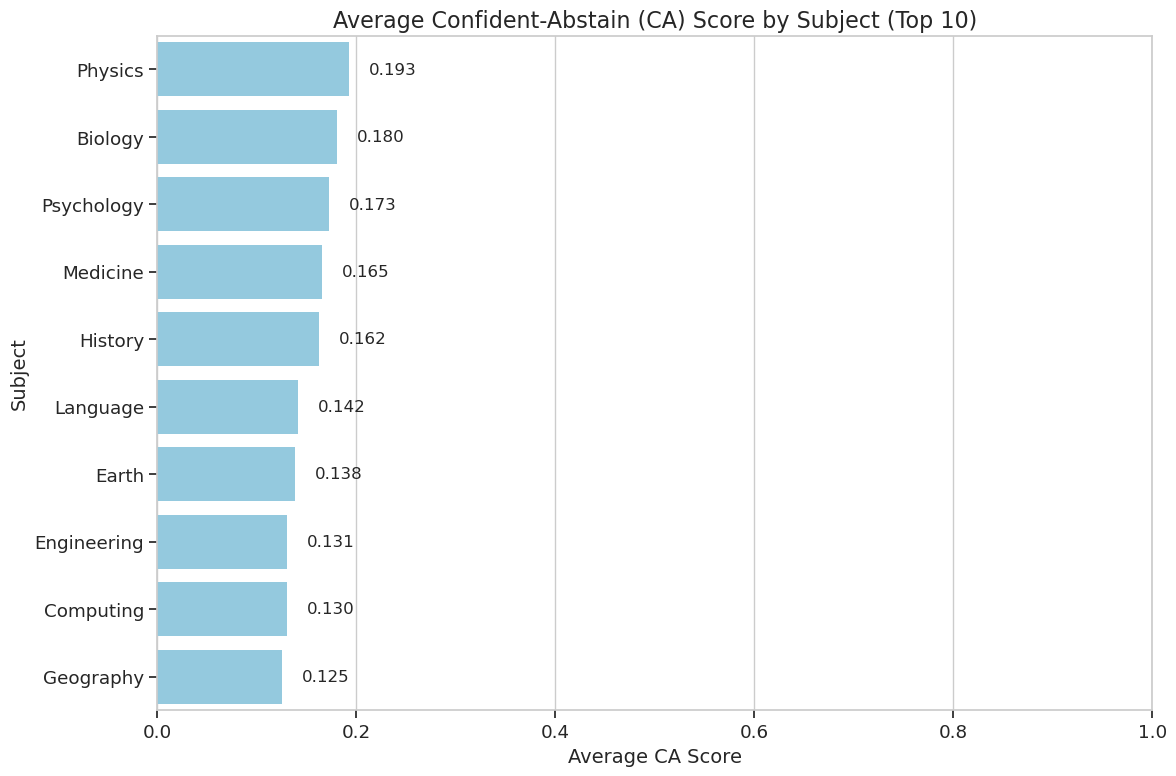

In [29]:
try:
    # Create a horizontal bar plot of CA scores by subject (top 10)
    plt.figure(figsize=(12, 8))

    # Get the top 10 subjects by CA score
    top_subjects = subject_summary.head(10)

    # Plot CA scores
    ax = sns.barplot(y='subject', x='ca_score', data=top_subjects, color='skyblue')

    # Add labels and title
    plt.title('Average Confident-Abstain (CA) Score by Subject (Top 10)', fontsize=16)
    plt.xlabel('Average CA Score', fontsize=14)
    plt.ylabel('Subject', fontsize=14)
    plt.xlim(0, 1)

    # Add value labels
    for i, v in enumerate(top_subjects['ca_score']):
        ax.text(v + 0.02, i, f'{v:.3f}', va='center', fontsize=12)

    plt.tight_layout()
    plt.show()
except NameError:
    print("No metrics data available.")


## Top Examples with Highest HEDGE Scores

Let's examine the top 5 examples with the highest HEDGE scores across all experiments to better understand what types of questions lead to high hedging behavior.


In [30]:
try:
    # Sort the metrics dataframe by hedge_score in descending order
    top_hedge_examples = metrics_df.sort_values('hedge_score', ascending=False).head(5)

    # Display the top examples with relevant information
    for i, (_, row) in enumerate(top_hedge_examples.iterrows(), 1):
        print(f"Example {i} - HEDGE Score: {row['hedge_score']:.4f}, CA Score: {row['ca_score']:.4f}")
        print(f"Question: {row['question']}")
        print(f"Form: {row['form']}, Permutation: {row['permutation']}, Label Type: {row['label_type']}")

        # Get the actual labels used in this experiment
        labels = []
        if row['label_type'] == 'alpha':
            if row['permutation'] == 'p1':
                labels = ["A", "B", "C", "D", "E"]  # Default alpha ordering
            else:
                # For other permutations, we'd need to extract from the data
                # This is a simplified approach
                labels = ["A", "B", "C", "D", "E"]  # Placeholder
        elif row['label_type'] == 'num':
            if row['permutation'] == 'p1':
                labels = ["1", "2", "3", "4", "5"]  # Default numeric ordering
            else:
                # For other permutations, we'd need to extract from the data
                labels = ["1", "2", "3", "4", "5"]  # Placeholder

        # Parse and display probabilities
        try:
            # Convert the JSON string to a dictionary
            import json
            probs = json.loads(row['canonical_probs'])
            print("Answer Probabilities (Canonical):")

            # Calculate Yes/No probabilities for clarity
            p_yes = probs.get("YY", 0) + probs.get("Y", 0)
            p_no = probs.get("N", 0) + probs.get("NN", 0)
            p_idk = probs.get("A", 0)

            # Display individual probabilities
            for label, prob in probs.items():
                print(f"  {label}: {prob:.4f}")

            # Display aggregated probabilities
            print(f"  Total Yes (YY+Y): {p_yes:.4f}")
            print(f"  Total No (N+NN): {p_no:.4f}")
            print(f"  IDK (A): {p_idk:.4f}")

            # Calculate the HEDGE score components
            s = 1.0 - p_idk
            if s > 0:
                r_yes = p_yes / s
                r_no = p_no / s
                print("\nHEDGE Components:")
                print(f"  s (1-p_IDK): {s:.4f}")
                print(f"  r_yes (p_yes/s): {r_yes:.4f}")
                print(f"  r_no (p_no/s): {r_no:.4f}")

                # Calculate entropy
                import numpy as np
                entropy = 0
                if r_yes > 0:
                    entropy -= r_yes * np.log(r_yes)
                if r_no > 0:
                    entropy -= r_no * np.log(r_no)
                normalized_entropy = entropy / np.log(2)
                print(f"  H(r)/log(2): {normalized_entropy:.4f}")
                print(f"  HEDGE = s * H(r)/log(2): {s * normalized_entropy:.4f}")

        except Exception as e:
            print(f"Could not parse probabilities: {e}")

        print(f"Canonical Label: {row['canonical_label']}")
        print(f"Correct Answer: {row['answer']}")
        print("-" * 80)
except NameError:
    print("No metrics data available.")


Example 1 - HEDGE Score: 1.0000, CA Score: 0.0000
Question: Does the process of oxidation involve the loss of electrons?
Form: V4, Permutation: p2, Label Type: num
Answer Probabilities (Canonical):
  YY: 0.5000
  Y: 0.0001
  A: 0.0000
  N: 0.0000
  NN: 0.5000
  Total Yes (YY+Y): 0.5001
  Total No (N+NN): 0.5000
  IDK (A): 0.0000

HEDGE Components:
  s (1-p_IDK): 1.0000
  r_yes (p_yes/s): 0.5001
  r_no (p_no/s): 0.5000
  H(r)/log(2): 1.0000
  HEDGE = s * H(r)/log(2): 0.9999
Canonical Label: YY
Correct Answer: Yes
--------------------------------------------------------------------------------
Example 2 - HEDGE Score: 1.0000, CA Score: 0.0000
Question: Is Mount Everest the highest mountain above sea level on Earth?
Form: V1, Permutation: p3, Label Type: alpha
Answer Probabilities (Canonical):
  YY: 0.5000
  Y: 0.0000
  A: 0.0000
  N: 0.5000
  NN: 0.0005
  Total Yes (YY+Y): 0.5000
  Total No (N+NN): 0.5005
  IDK (A): 0.0000

HEDGE Components:
  s (1-p_IDK): 1.0000
  r_yes (p_yes/s): 0.500